# Importy, wizualizacja
(Należy odpalić i schować).

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import Compose, Lambda, ToTensor

%matplotlib inline


def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28 * 28) / 255.0
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().cuda() / 255.0)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())

        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap="gray")
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())

    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap="gray")
            axes[i].set_xticks(())
            axes[i].set_yticks(())

    plt.show()


def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    _ = plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().cuda())
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())

    for class_idx in range(10):
        indices = data.targets == class_idx
        plt.scatter(reduced_z[indices, 0], reduced_z[indices, 1], s=2.0, label=labels[class_idx])

    plt.legend()
    plt.show()


torch.manual_seed(1337)
batch_size = 128
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(
    root=".", train=True, transform=transforms, download=True
)  # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Auoenkoder i modele generatywne

Na dzisiejszych zajęciach poznamy model autoenkodera i pokażemy, kolejno:
1. Jak jego ukrytą reprezentację można wykorzystać do uczenia częściowo nadzorowanego
2. Jak można wymusić na autoenkoderze generatywność i "zmusić" go do generowania nowych przykładów podobnych do tych ze zbioru treningowego.


## Podstawowy autoenkoder

![Auto-encoder](https://raw.githubusercontent.com/gmum/ml2023-24/master/lab/resources/ae.png)

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x 
$$
$$
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$
 

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności.  

## Zadanie 1. Vanilla Autoencoder (1 pkt.)

Należy zaimplementować enkoder i dekoder. Kolejne warstwy w enkoderze mają mieć następującą liczbę neuronów: [784, 128, 128, 64, `latent_dim`]. Analogicznie dekoder ma wyglądać następująco: [`latent_dim`, 64, 128, 128, 784]. Wejście i wyjście mają 784 neurony, jako że taka jest wymiarowość MNIST-a. Wartość `latent_dim` dostajemy na wejściu do konstruktora (`latent_dim`).

Po warstwach ukrytych chcemy mieć aktywacje ReLU, **na końcu enkodera nie stosujemy żadnej aktywacji**, na końcu dekodera stosujemy aktywację sigmoidalną.

**Pytanie: Dlaczego na końcu dekodera chcemy mieć sigmoidę?**

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.61MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 252kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.36MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Epoch 1/25, Loss: 0.0427
Epoch 2/25, Loss: 0.0260
Epoch 3/25, Loss: 0.0221
Epoch 4/25, Loss: 0.0202
Epoch 5/25, Loss: 0.0191
Epoch 6/25, Loss: 0.0183
Epoch 7/25, Loss: 0.0179
Epoch 8/25, Loss: 0.0175
Epoch 9/25, Loss: 0.0172
Epoch 10/25, Loss: 0.0169
Epoch 11/25, Loss: 0.0168
Epoch 12/25, Loss: 0.0167
Epoch 13/25, Loss: 0.0166
Epoch 14/25, Loss: 0.0165
Epoch 15/25, Loss: 0.0164
Epoch 16/25, Loss: 0.0163
Epoch 17/25, Loss: 0.0162
Epoch 18/25, Loss: 0.0161
Epoch 19/25, Loss: 0.0160
Epoch 20/25, Loss: 0.0160
Epoch 21/25, Loss: 0.0159
Epoch 22/25, Loss: 0.0159
Epoch 23/25, Loss: 0.0158
Epoch 24/25, Loss: 0.0158
Epoch 25/25, Loss: 0.0157


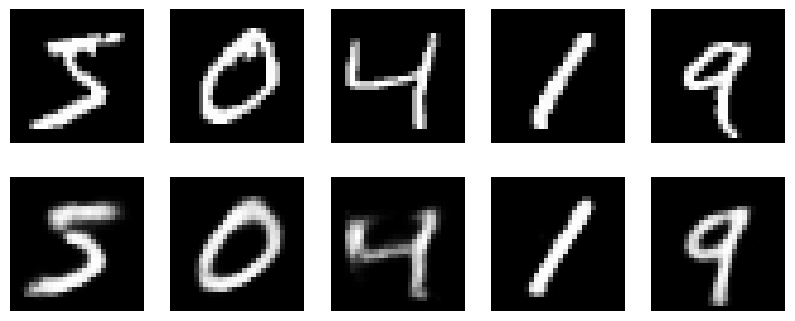

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
latent_dim = 10
batch_size = 64
learning_rate = 5e-3
epochs = 25

# Data loading and preprocessing (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Autoencoder implementation
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim: int):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # No activation at the end of the encoder
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()  # Sigmoid activation at the output
        )

    def encode(self, x: torch.Tensor):
        return self.encoder(x)

    def decode(self, encoded: torch.Tensor):
        return self.decoder(encoded)

    def forward(self, x: torch.Tensor):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

autoencoder = AutoEncoder(latent_dim=latent_dim)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
rec_loss_fn = nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []
    for step, (x, _) in enumerate(train_loader):
        x = x  
        encoded, decoded = autoencoder(x)
        loss_val = rec_loss_fn(decoded, x)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        epoch_losses.append(loss_val.item())
    
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {np.mean(epoch_losses):.4f}")

# Function to visualize reconstruction
def visualize_reconstruction(data, model, n=5):
    model.eval()
    samples = next(iter(DataLoader(data, batch_size=n)))
    inputs = samples[0]
    _, outputs = model(inputs)
    outputs = outputs.detach().numpy()

    fig, axes = plt.subplots(2, n, figsize=(10, 4))
    for i in range(n):
        axes[0, i].imshow(inputs[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Visualize reconstructions
visualize_reconstruction(train_data, autoencoder)


## Część 1: Uczenie częściowo nadzorowane (semi-supervised learning)

W praktyce zbudowanie w pełni nadzorowanego zbioru danych często jest kosztowne. Jeżeli chcielibyśmy uczyć się klasyfikacji obrazków naturalnych, to zdobycie dużych zbiorów danych nie jest trudne (możemy je zescrapować z internetu), natomiast zdobycie do nich etykiet wymagałoby czasu człowieka, który zidentyfikowałby, co się znajduje na poszczególnych obrazkach. W niektórych przypadkach etykietowanie jest jeszcze bardziej kosztowne - w zagadnieniu segmentacji, gdzie chcemy każdemu pikselowi w obrazku przypisać jedną klasę, zapisanie etykiety dla jednego obrazka może zająć ekspertowi kilka godzin.

Problem liczby etykiet i ich jakości jest w praktyce bardzo istotny. Dlatego też w praktyce chcielibyśmy mieć metody głębokiego uczenia, które potrafią wykorzystać dane, dla których nie mamy etykiet. W poniższym przykładzie zbudujemy prosty model częściowo nadzorowany z wykorzystaniem autoenkodera.


## Zadanie 2. Uczenie częściowo nadzorowane (3 pkt.)

Załóżmy, że z 60.000 przykładów zbiorze MNIST tylko 100 przykładów ma podaną etykietę, a dla pozostałych 59.900 nie mamy etykiety - tym samym mamy problem uczenia częściowo nadzorowanego. Nasze 100 przykładów z etykietami zdefiniowane są w zmiennej `labeled_data`.

1. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po **wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać**. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.
2. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.
3. Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.


In [51]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(
    root=".", train=False, transform=transforms, download=True
)  # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [53]:
### Tutaj zaimplementuj i wytrenuj model baseline'owy

In [55]:
# Baseline Model

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np

# Załadowanie danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])
train_data = MNIST(root='./data', train=True, transform=transform, download=True)
test_data = MNIST(root='./data', train=False, transform=transform, download=True)

# Przygotowanie labeled_data
labeled_data = Subset(train_data, range(100))
labeled_loader = DataLoader(labeled_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5000, shuffle=False)

# Model baseline
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # 10 klas wyjściowych
        )

    def forward(self, x):
        return self.network(x)

# Funkcja do trenowania modelu
def train_model(model, optimizer, criterion, train_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        losses = []
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {np.mean(losses):.4f}")

# Funkcja do testowania modelu
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Trenowanie modelu baseline
print("Training Baseline Model")
baseline_model = BaselineModel()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(baseline_model, optimizer_baseline, criterion, labeled_loader, epochs=20)
baseline_accuracy = test_model(baseline_model, test_loader)

Training Baseline Model
Epoch 1/20, Loss: 2.3145
Epoch 2/20, Loss: 2.2336
Epoch 3/20, Loss: 2.1194
Epoch 4/20, Loss: 1.9535
Epoch 5/20, Loss: 1.9599
Epoch 6/20, Loss: 1.7629
Epoch 7/20, Loss: 1.4861
Epoch 8/20, Loss: 1.4091
Epoch 9/20, Loss: 1.0555
Epoch 10/20, Loss: 0.9764
Epoch 11/20, Loss: 0.8553
Epoch 12/20, Loss: 0.6911
Epoch 13/20, Loss: 0.6303
Epoch 14/20, Loss: 0.5038
Epoch 15/20, Loss: 0.4416
Epoch 16/20, Loss: 0.2980
Epoch 17/20, Loss: 0.2622
Epoch 18/20, Loss: 0.2146
Epoch 19/20, Loss: 0.1764
Epoch 20/20, Loss: 0.1667
Test Accuracy: 63.56%


In [57]:
### Tutaj zaimplementuj i wytrenuj klasyfikator oparty o reprezentację podaną przez autoenkoder.

In [59]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
import numpy as np

# Załadowanie danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the 28x28 image to 784
])
train_data = MNIST(root='./data', train=True, transform=transform, download=True)
test_data = MNIST(root='./data', train=False, transform=transform, download=True)

# Przygotowanie labeled_data
labeled_data = Subset(train_data, range(100))
labeled_loader = DataLoader(labeled_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5000, shuffle=False)

# Załadowanie wytrenowanego Autoenkodera
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Instancja Autoenkodera
latent_dim = 10
autoencoder = AutoEncoder(latent_dim=latent_dim)

# Zakładamy, że autoencoder jest już wytrenowany
# Ekstrahowanie ukrytych reprezentacji
encoded_data = []
encoded_labels = []
for x, y in labeled_loader:
    with torch.no_grad():
        encoded= autoencoder.encoder(x)
        encoded_data.append(encoded)
        encoded_labels.append(y)
encoded_data = torch.cat(encoded_data)
encoded_labels = torch.cat(encoded_labels)
encoded_dataset = torch.utils.data.TensorDataset(encoded_data, encoded_labels)
encoded_loader = DataLoader(encoded_dataset, batch_size=32, shuffle=True)

# Model klasyfikatora
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10)  # 10 klas wyjściowych
        )

    def forward(self, x):
        return self.network(x)

# Funkcja do trenowania modelu

def train_model(model, optimizer, criterion, train_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        losses = []
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {np.mean(losses):.4f}")

# Funkcja do testowania modelu

def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            encoded = autoencoder.encoder(x)
            output = model(encoded)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y).sum().item()
            total += y.size(0)
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Trenowanie klasyfikatora z autoenkoderem
print("Training Classifier with Autoencoder")
classifier = Classifier()
optimizer_classifier = optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_model(classifier, optimizer_classifier, criterion, encoded_loader, epochs=20)
classifier_accuracy = test_model(classifier, test_loader)

Training Classifier with Autoencoder
Epoch 1/20, Loss: 2.2855
Epoch 2/20, Loss: 2.3300
Epoch 3/20, Loss: 2.2886
Epoch 4/20, Loss: 2.3013
Epoch 5/20, Loss: 2.2941
Epoch 6/20, Loss: 2.2972
Epoch 7/20, Loss: 2.2878
Epoch 8/20, Loss: 2.2537
Epoch 9/20, Loss: 2.3007
Epoch 10/20, Loss: 2.2803
Epoch 11/20, Loss: 2.2980
Epoch 12/20, Loss: 2.2707
Epoch 13/20, Loss: 2.2833
Epoch 14/20, Loss: 2.2776
Epoch 15/20, Loss: 2.2968
Epoch 16/20, Loss: 2.2715
Epoch 17/20, Loss: 2.2905
Epoch 18/20, Loss: 2.2731
Epoch 19/20, Loss: 2.2816
Epoch 20/20, Loss: 2.2627
Test Accuracy: 11.35%


## Dygresja: Inne zagadnienia uczenia ze słabym nadzorem
Podany powyżej przykład jest bardzo prostym podejściem do problemu uczenia danych ze słabym nadzorem. Dla zainteresowanych trochę więcej materiałów:

* [Praca przeglądowa o problemie słabego nadzoru](https://academic.oup.com/nsr/article-pdf/5/1/44/31567770/nwx106.pdf)
* [Pseudo-labeling do uczenia częściowo nazdorowanego](https://github.com/emintham/Papers/blob/master/Lee-%20Pseudo-Label:%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf) - W tym podejściu do uczenia częściowo nadzorowanego trenujemy model na poetykietowanych danych, używamy jego predykcji żeby poetykietować resztę danych i uczymy model z takimi (narzuconymi przez siebie) etykietami. Wbrew intuicji to podejście dziala całkiem dobrze.
* [Przegląd metod self-supervision](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning.html) - Czy możemy się uczyć z danych na podstawie łatwych do otrzymania etykiet (np. o ile stopni zdjęcie zostało obrócone)?
* [Przegląd metod kontrastywnych](https://arxiv.org/abs/2011.00362) - Czy możemy się uczyć reprezentacji na podstawie szukania podobieństw między przykładami?

# Część 2: Modele generatywne

Interesującym zastosowaniem sieci neuronowych jest generowanie nowych przykładów ze zbioru treningowego, np. [generowanie nowych twarzy](https://thispersondoesnotexist.com/) albo [generowanie tekstu](https://transformer.huggingface.co/doc/gpt2-large). Na dzisiejszych zajęciach spróbujemy zbudować prosty model generatywny oparty o autoenkoder.

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.7MB/s]


Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 866kB/s]


Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 8.29MB/s]


Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw



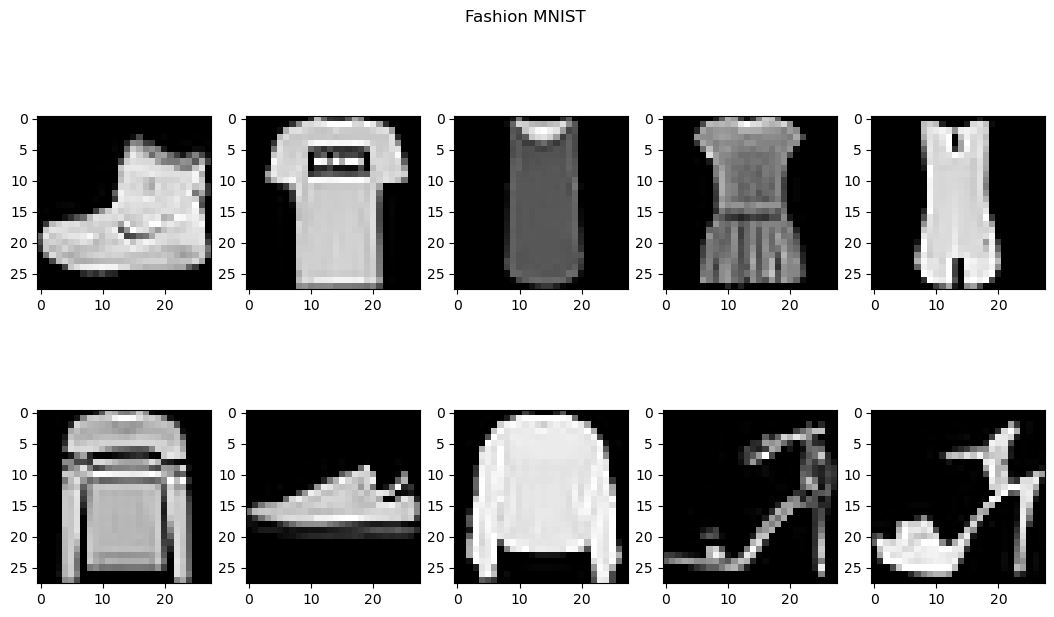

In [62]:
# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root=".", train=True, transform=transforms, download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap="gray")
plt.suptitle("Fashion MNIST")
plt.show()


## Zadanie 3: WAE-MMD (3 pkt.)
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera (enkoder + dekoder), podobną do tej zaprezentowanej w Zadaniu 1. Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować pętlę uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



In [238]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

class WAEMMD(nn.Module):
    def __init__(self, latent_dim: int):
        super(WAEMMD, self).__init__()
        self.latent_dim = latent_dim
        
        # Enkoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, latent_dim)
        )
        
        # Dekoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1),
            nn.Sigmoid()  # Normalizowanie do zakresu [0, 1]
        )
    
    def encode(self, x):
        x = self.encoder(x)
        x = F.pad(x, (0, 3, 0, 3))
        return x.view(x.size(0), -1)  # Spłaszczenie, aby dopasować do warstwy Linear

    
    def decode(self, z: torch.Tensor):
        x = self.decoder(z)
        return x 

    def forward(self, x):
        z = self.encode(x)  # kodowanie do przestrzeni latentnej
        recon_x = self.decode(z)  # dekodowanie z przestrzeni latentnej
        return recon_x, z

In [240]:
def mmd_loss(self, z: torch.Tensor, sigma: float):
    # Obliczanie MMD pomiędzy próbkami z przestrzeni latentnej
    n = z.size(0)
    
    # Obliczamy macierze podobieństwa
    xx = torch.matmul(z, z.t())
    zz = torch.matmul(z, z.t())
    xz = torch.matmul(z, z.t())

    # Obliczanie wartości kernela RBF
    xx = torch.exp(- (xx / (2. * sigma ** 2)))
    zz = torch.exp(- (zz / (2. * sigma ** 2)))
    xz = torch.exp(- (xz / (2. * sigma ** 2)))

    return torch.mean(xx + zz - 2. * xz)


In [242]:
def train(epochs, wae, train_loader, optimizer, sigma, C):
    wae.train()
    for epoch in range(epochs):
        for data, _ in train_loader:
            data = data.view(-1, 1, 28, 28).to(device)  # Przywracamy dane do formatu [batch_size, 1, 28, 28]

            # Forward pass
            recon_data, z = wae(data)
            rint(f"recon_data shape: {recon_data.shape}, z shape: {z.shape}")

            # Błąd rekonstrukcji
            reconstruction_loss = nn.BCELoss()(recon_data, data)  # Bez spłaszczania danych

            # MMD loss
            mmd_loss = wae.mmd_loss(z, sigma)

            # Łączny koszt
            loss = reconstruction_loss + C * mmd_loss

            # Optymalizacja
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


In [244]:
def plot_samples(model):
    sampled_z = torch.randn(20, model.latent_dim).to(device)
    generated = model.decode(sampled_z)

    # Rysowanie wygenerowanych próbek
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()


In [246]:
# Parametry
latent_dim = 50  # Wymiar przestrzeni latentnej
sigma = 1.0      # Parametr rozrzutu w MMD
C = 10           # Waga dla MMD loss
epochs = 50      # Liczba epok
batch_size = 64  # Rozmiar batcha
learning_rate = 1e-3

# Inicjalizacja modelu i optymalizatora

wae = WAEMMD(latent_dim).to(device)
optimizer = optim.Adam(wae.parameters(), lr=learning_rate)

# Wczytanie danych
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Trening
train(epochs, wae, train_loader, optimizer, sigma, C)

# Generowanie próbek po treningu
plot_samples(wae)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (67x53 and 50x3136)

Epoch: 0 | train loss: 0.07037


<Figure size 432x288 with 0 Axes>

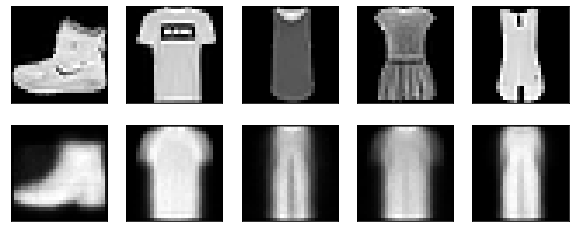

<Figure size 432x288 with 0 Axes>

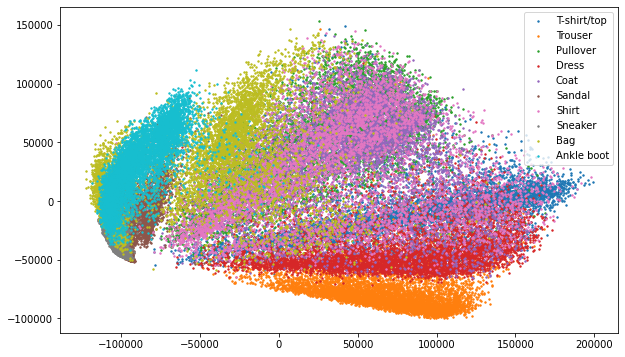

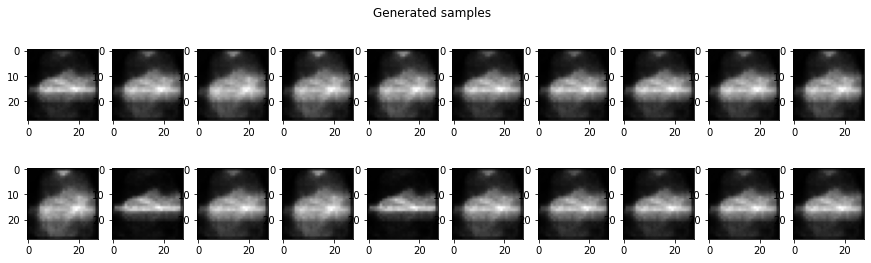

Epoch: 1 | train loss: 0.04474
Epoch: 2 | train loss: 0.03696
Epoch: 3 | train loss: 0.03389
Epoch: 4 | train loss: 0.03129
Epoch: 5 | train loss: 0.02966
Epoch: 6 | train loss: 0.02816
Epoch: 7 | train loss: 0.02674
Epoch: 8 | train loss: 0.02590
Epoch: 9 | train loss: 0.02513
Epoch: 10 | train loss: 0.02462


<Figure size 432x288 with 0 Axes>

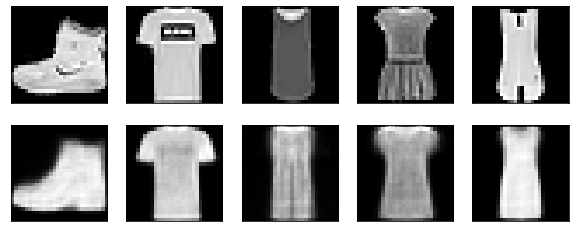

<Figure size 432x288 with 0 Axes>

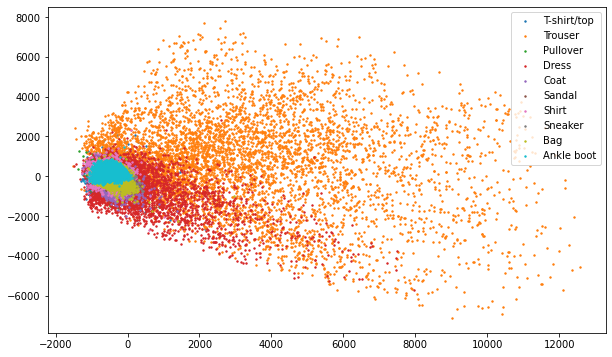

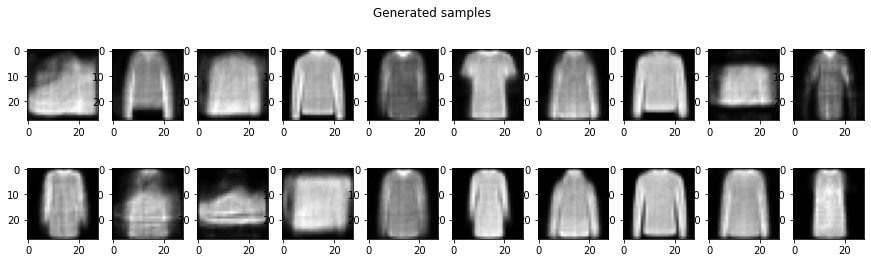

Epoch: 11 | train loss: 0.02422
Epoch: 12 | train loss: 0.02381
Epoch: 13 | train loss: 0.02344
Epoch: 14 | train loss: 0.02314
Epoch: 15 | train loss: 0.02293
Epoch: 16 | train loss: 0.02267
Epoch: 17 | train loss: 0.02241
Epoch: 18 | train loss: 0.02222
Epoch: 19 | train loss: 0.02216
Epoch: 20 | train loss: 0.02185


<Figure size 432x288 with 0 Axes>

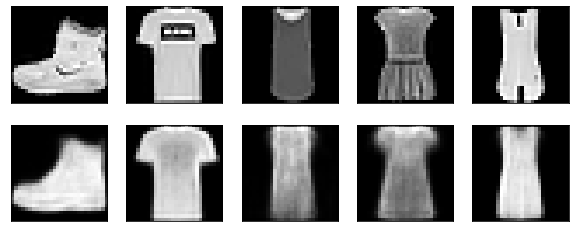

<Figure size 432x288 with 0 Axes>

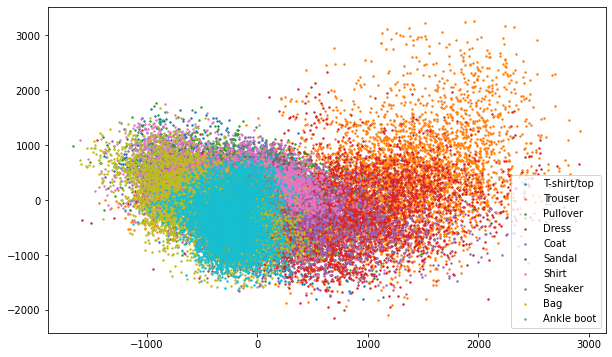

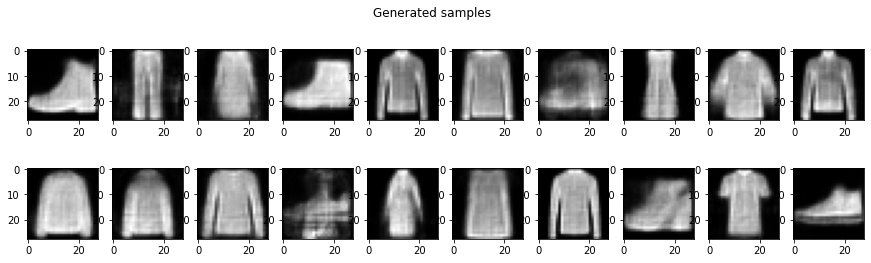

Epoch: 21 | train loss: 0.02183
Epoch: 22 | train loss: 0.02162
Epoch: 23 | train loss: 0.02164
Epoch: 24 | train loss: 0.02133
Epoch: 25 | train loss: 0.02141
Epoch: 26 | train loss: 0.02131
Epoch: 27 | train loss: 0.02118
Epoch: 28 | train loss: 0.02106
Epoch: 29 | train loss: 0.02093
Epoch: 30 | train loss: 0.02095


<Figure size 432x288 with 0 Axes>

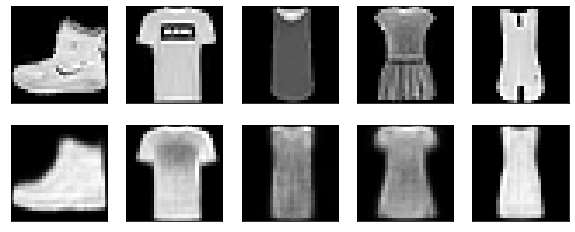

<Figure size 432x288 with 0 Axes>

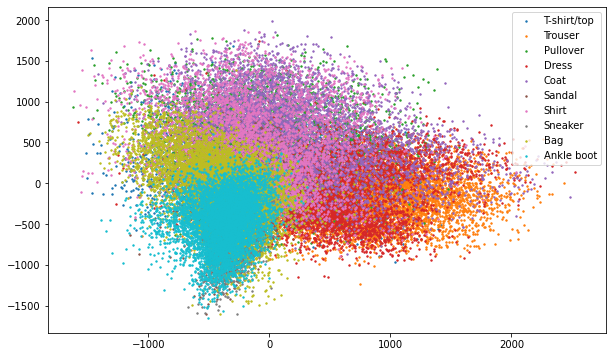

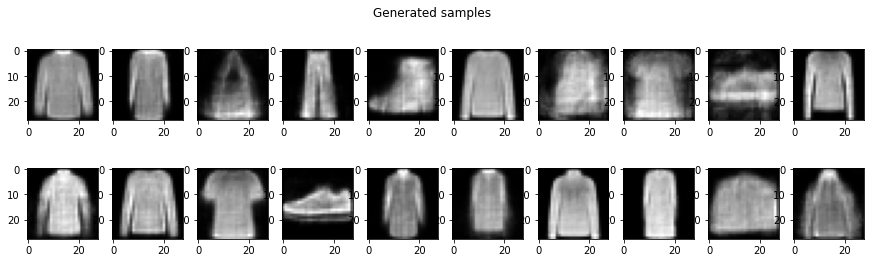

Epoch: 31 | train loss: 0.02098
Epoch: 32 | train loss: 0.02076
Epoch: 33 | train loss: 0.02072
Epoch: 34 | train loss: 0.02069
Epoch: 35 | train loss: 0.02077
Epoch: 36 | train loss: 0.02058
Epoch: 37 | train loss: 0.02052
Epoch: 38 | train loss: 0.02051
Epoch: 39 | train loss: 0.02030
Epoch: 40 | train loss: 0.02044


<Figure size 432x288 with 0 Axes>

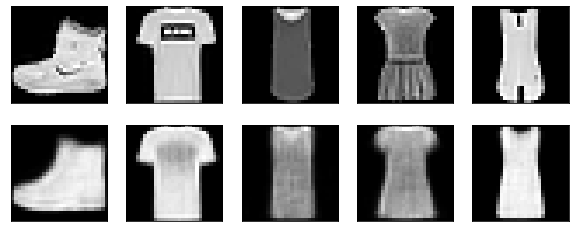

<Figure size 432x288 with 0 Axes>

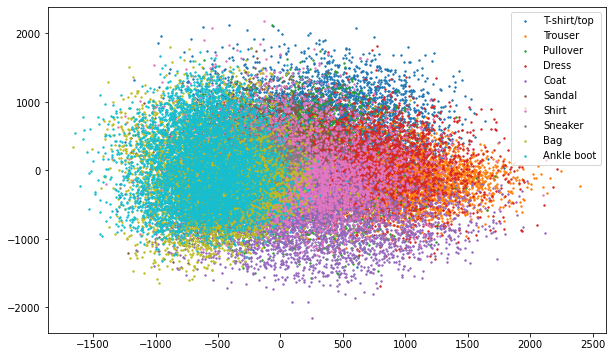

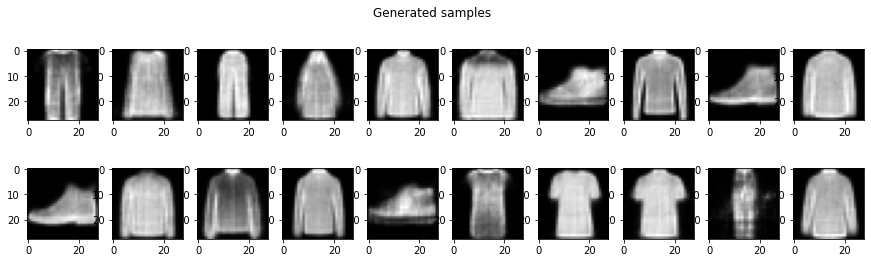

Epoch: 41 | train loss: 0.02033
Epoch: 42 | train loss: 0.02026
Epoch: 43 | train loss: 0.02026
Epoch: 44 | train loss: 0.02021
Epoch: 45 | train loss: 0.02007
Epoch: 46 | train loss: 0.02011
Epoch: 47 | train loss: 0.02014
Epoch: 48 | train loss: 0.02007
Epoch: 49 | train loss: 0.01999
Epoch: 50 | train loss: 0.01998


<Figure size 432x288 with 0 Axes>

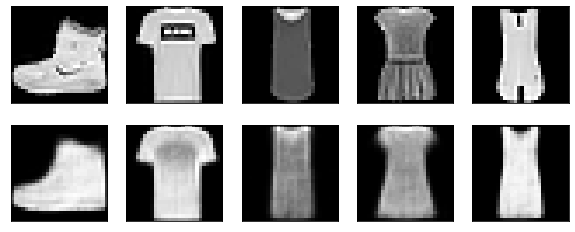

<Figure size 432x288 with 0 Axes>

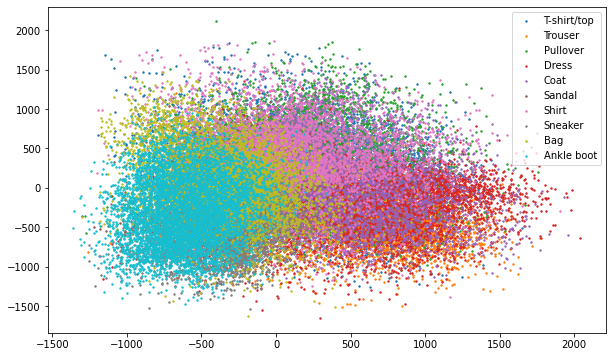

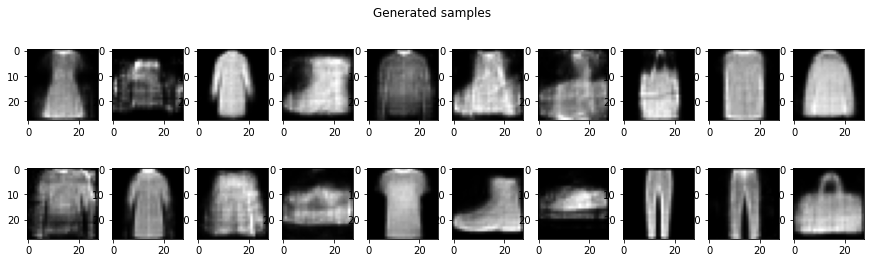

Epoch: 51 | train loss: 0.01996
Epoch: 52 | train loss: 0.01992
Epoch: 53 | train loss: 0.01986
Epoch: 54 | train loss: 0.01977
Epoch: 55 | train loss: 0.01978
Epoch: 56 | train loss: 0.01975
Epoch: 57 | train loss: 0.01974
Epoch: 58 | train loss: 0.01973
Epoch: 59 | train loss: 0.01968
Epoch: 60 | train loss: 0.01972


<Figure size 432x288 with 0 Axes>

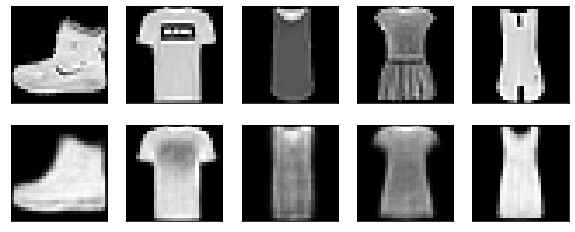

<Figure size 432x288 with 0 Axes>

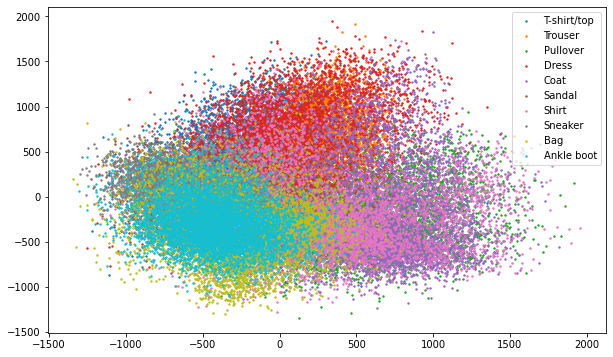

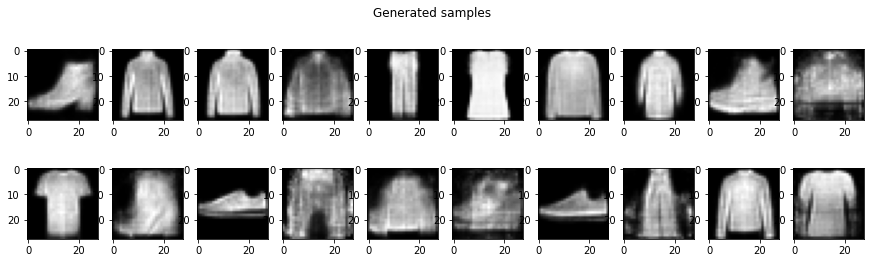

Epoch: 61 | train loss: 0.01971
Epoch: 62 | train loss: 0.01954
Epoch: 63 | train loss: 0.01954
Epoch: 64 | train loss: 0.01950
Epoch: 65 | train loss: 0.01960
Epoch: 66 | train loss: 0.01945
Epoch: 67 | train loss: 0.01943
Epoch: 68 | train loss: 0.01943
Epoch: 69 | train loss: 0.01941
Epoch: 70 | train loss: 0.01941


<Figure size 432x288 with 0 Axes>

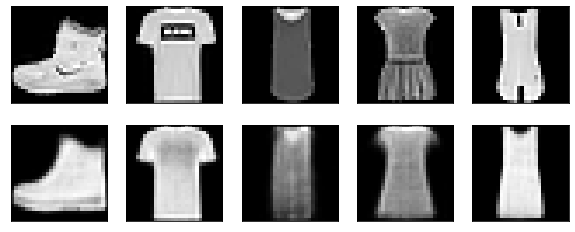

<Figure size 432x288 with 0 Axes>

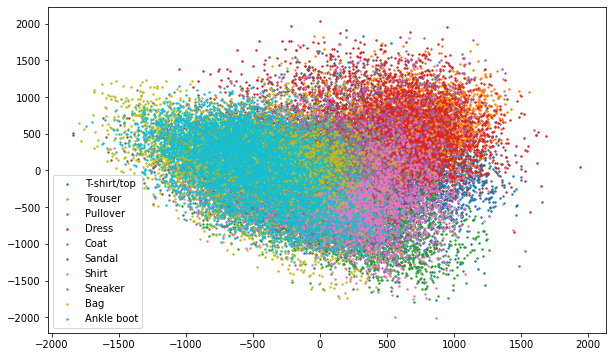

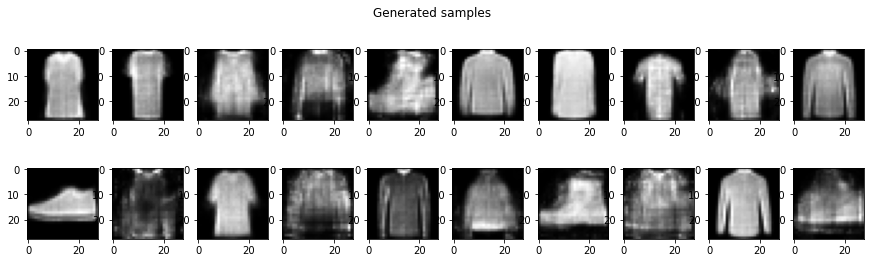

Epoch: 71 | train loss: 0.01953
Epoch: 72 | train loss: 0.01936
Epoch: 73 | train loss: 0.01929
Epoch: 74 | train loss: 0.01939
Epoch: 75 | train loss: 0.01931
Epoch: 76 | train loss: 0.01933
Epoch: 77 | train loss: 0.01921
Epoch: 78 | train loss: 0.01934
Epoch: 79 | train loss: 0.01922
Epoch: 80 | train loss: 0.01930


<Figure size 432x288 with 0 Axes>

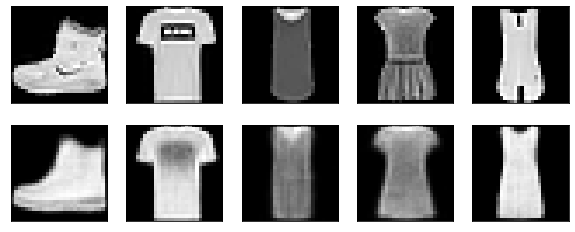

<Figure size 432x288 with 0 Axes>

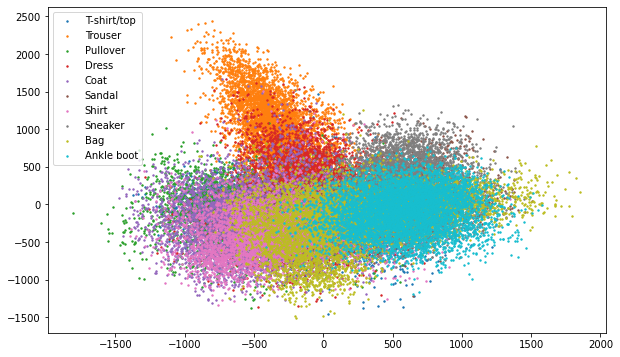

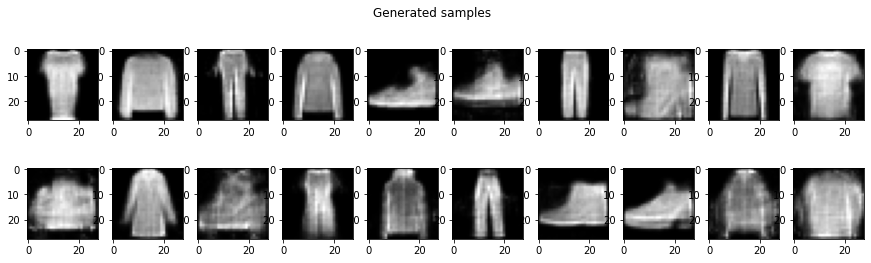

Epoch: 81 | train loss: 0.01929
Epoch: 82 | train loss: 0.01928
Epoch: 83 | train loss: 0.01914
Epoch: 84 | train loss: 0.01919
Epoch: 85 | train loss: 0.01914
Epoch: 86 | train loss: 0.01919
Epoch: 87 | train loss: 0.01909
Epoch: 88 | train loss: 0.01913
Epoch: 89 | train loss: 0.01908
Epoch: 90 | train loss: 0.01907


<Figure size 432x288 with 0 Axes>

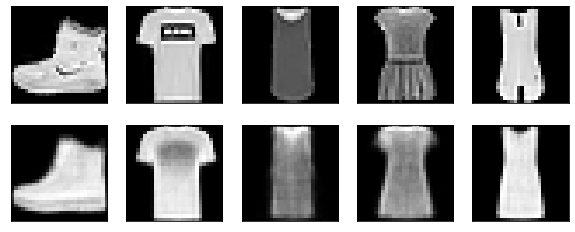

<Figure size 432x288 with 0 Axes>

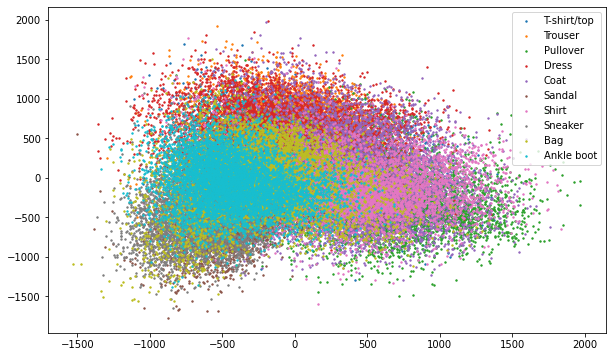

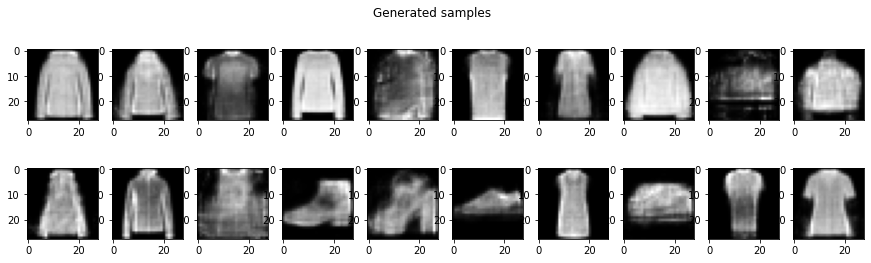

Epoch: 91 | train loss: 0.01913
Epoch: 92 | train loss: 0.01903
Epoch: 93 | train loss: 0.01900
Epoch: 94 | train loss: 0.01906
Epoch: 95 | train loss: 0.01902
Epoch: 96 | train loss: 0.01896
Epoch: 97 | train loss: 0.01901
Epoch: 98 | train loss: 0.01902
Epoch: 99 | train loss: 0.01896


In [5]:
def plot_samples(model):
    # Important part - sampling from normal distribution and passing the results through the decoder.
    sampled_z = torch.randn(20, model.latent_dim).cuda()
    generated = model.decode(sampled_z)

    # Plotting the results
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

sigma: float = ...
C: float = ...
epochs: int = ...

wae = ...

...

for epoch in range(epochs):
    ...
    
    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)

## Więcej materiałów o modelach generatywnych

* [Wykład o uczeniu nienadzorowanym i VAE](https://www.youtube.com/watch?v=f0s-uvvXvWg&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=10) - Interesujący wykład badaczy z DeepMindu zagłebiający się w to, dlaczego nienadzorowane uczenie się reprezentacji jest cenne i jak wykorzystać do tego VAE (model podobny do WAE). Polecamy też pozostałe wykłady z serii.
* [Cramer-Wold Autoencoder](https://arxiv.org/abs/1805.09235) - jak zaimplementować koszt WAE-MMD bez potrzeby samplowania w przestrzeni ukrytej?
